## Introduction to big data tools

Python packages like numpy, pandas, sklearn, seaborn etc. make the data manipulation and ML tasks very convenient. For most data analysis tasks, the python pandas package is good enough. You can do all sorts of data manipulation and it is compatible with building ML models.

But, as your data gets bigger, bigger than what you can fit in the RAM, pandas won’t be sufficient. When it comes to working with really large datasets, the run time can become very high due to memory constraints. The standard libraries like pandas and numpy usually work well if the dataset is small enough (upto 2-3 GBs). Unfortunately, these popular libraries were not designed to scale beyond a single machine and given a large dataset to analyze (like 8/16/32  GB or beyond), it would be difficult to process and model it using standard means. 

## Dask

Dask is popularly known as a ‘parallel computing’ python library that has been designed to run across multiple systems. Dask can efficiently perform parallel computations on a single machine using multi-core CPUs. For example, if you have a quad core processor, Dask can effectively use all 4 cores of your system simultaneously for processing. In order to use lesser memory during computations, Dask keeps the complete data on the disk, and uses chunks of data (smaller parts, rather than the whole data) from the disk for processing. During the processing, the intermediate values generated (if any) are discarded as soon as possible, to save the memory consumption.

This way Dask supports the Pandas dataframe and Numpy array data structures to analyze large datasets. Basically, Dask lets you scale pandas and numpy with minimum changes in your code format.

Installation: https://docs.dask.org/en/latest/install.html

Some additional resources for diving deeper into Dask and common operations:

#### Dask documentation: https://docs.dask.org/en/latest/

#### Detailed book/tutorial: https://livebook.manning.com/book/data-science-at-scale-with-python-and-dask/about-this-book/

#### Parallel computing: https://ckyrkou.medium.com/an-introduction-to-parallel-computing-dffa6b79e57c

In [1]:
import pandas as pd
import numpy as np
#import geopandas as gpd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from datetime import datetime
from matplotlib import pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

### Dask arrays

A large numpy array is divided into smaller arrays which, when grouped together, form the Dask array. In simple words, Dask arrays are distributed numpy arrays. Every operation on a Dask array triggers operations on the smaller numpy arrays, each using a core on the machine. Thus all available cores are used simultaneously enabling computations on arrays which are larger than the memory size.

<img src="array.png" width="500">


A number of numpy arrays are arranged into grids to form a Dask array. While creating a Dask array, you can specify the chunk size which defines the size of the numpy arrays. For instance, if you have 10 values in an array and you give the chunk size as 5, it will return 2 numpy arrays with 5 values each.

In [2]:
import dask.array as da
# example
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

This creates a 10000x10000 array of random numbers uniformly distrubuted between 0 and 1. The full object would contain 100M numbers - not impossible, but challenging to handle as a single variable.

Dask would represent it as many numpy arrays of size specified by chunk=1000x1000 (or smaller if the array cannot be divided evenly). 

In this case there are 100 (10x10) numpy arrays of size 1000x1000.

The 'compute()' function changes the result to a numpy array. If you don't call compute, the output remains as a dask object storing the sequency of suggested computations, but not running those just yet ("lazy" approach).

#### Important Note: 

Before calling the compute() function, any dask object remains what is called a Dask 'collection', which essentially stores all the computations called before but not actually performs them. With the compute method, all computations called before are performed simultaneously and the object transform from a dask collection to a concrete value in local memory.

It is thus important to know when and when not to call the compute method. The approach often breaks down if we try to bring the entire dataset as output back to local RAM. So if are dealing with data that exceeds machine RAM, it is better not to obtain the entire data as output. However, we can still call the compute method for obtaining low-memory outputs like computations for selected arrays (or columns in a dataframe) or aggregations.

In [3]:
x.compute()

array([[0.92050999, 0.86470952, 0.49310283, ..., 0.26282783, 0.31571686,
        0.32300953],
       [0.20879323, 0.05303583, 0.08689087, ..., 0.33666976, 0.45133742,
        0.39582901],
       [0.84053037, 0.26616436, 0.31656951, ..., 0.91714319, 0.24917021,
        0.59353637],
       ...,
       [0.65379708, 0.22427198, 0.10412469, ..., 0.38310543, 0.02367882,
        0.35724735],
       [0.00854736, 0.332536  , 0.34615862, ..., 0.46219968, 0.36981041,
        0.0048605 ],
       [0.31843602, 0.00222637, 0.22914735, ..., 0.33549446, 0.09766423,
        0.4738338 ]])

### Persist data in memory
If you know you have the available RAM for your dataset then you can persist data in memory. Essentially this operation temporarily saves the data in your computer memory if the size of the data does not exceed your RAM.

This allows future computations to be much faster. 

Let's check how much time does it take to calculate sum of the above array

In [4]:
# calculate sum and call compute to print the output
## x.sum() alone won't print the output. we need to .compute()
## %time calls the information about needed computing time

%time x.sum().compute()

Wall time: 1.03 s


49996858.58615881

In [5]:
# now let's try the persist() function and then check the time
## if all chunks can be handled in the memory together, call .persist() --> faster computation
## this can be done for instance when we operate with some filtered data (a slice that actually fits in the memory)

y = x.persist()
%time y.sum().compute()

Wall time: 114 ms


49996858.58615881

The computation time almost reduces to 1/10th of the original time after calling the persist() function

### Dask dataframes

We saw that multiple numpy arrays are grouped together to form a Dask array. Similar to a Dask array, a Dask dataframe consists of multiple smaller pandas dataframes which are stored in disk/cluster as a single dask object. These Pandas DataFrames may live on disk for computing on a single machine, or on many different machines in a cluster. One Dask DataFrame operation triggers many operations on the constituent Pandas DataFrames.

A large pandas dataframe splits row-wise to form multiple smaller dataframes. These smaller dataframes are present on a disk of a single machine, or multiple machines (thus allowing to store datasets of size larger than the memory). Each computation on a Dask dataframe parallelizes operations over the different chunks on the dataframe.


<img src="dataframe.png" width="300">


### Common uses:

Dask DataFrame is used in situations where Pandas is commonly needed, usually when Pandas fails due to data size or computation speed.

1. Manipulating large datasets, even when those datasets don’t fit in memory
2. Accelerating long computations by using many cores
3. Distributed computing on large datasets with standard Pandas operations like groupby, join, and time series computations

The APIs offered by the Dask dataframe are very similar in syntax to that of the pandas dataframe.

#### Now, let’s perform some basic operations on Dask dataframes

Let's download 2020 TLC yellow taxi data for first few months. Generally, TLC data contains millions of records even for a single month and pandas usually has a hard time reading and performing computations on it. Anyway, pandas either altogether fails to load data for multiple months or takes a huge time reading it.

In [2]:
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-01.csv > yellow_tripdata_2020-01.csv
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-02.csv > yellow_tripdata_2020-02.csv
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-03.csv > yellow_tripdata_2020-03.csv
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-04.csv > yellow_tripdata_2020-04.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  566M  100  566M    0     0  2069k      0  0:04:40  0:04:40 --:--:-- 3554k  0:03:43 1061k1932k      0  0:04:59  0:01:15  0:03:44  701k0     0  1683k      0  0:05:44  0:01:55  0:03:49  912k28  0:03:48  541k522k      0  0:06:20  0:02:33  0:03:47 1024k2398k17  0:03:59  0:01:18 3612k 0     0  1865k      0  0:05:10  0:04:05  0:01:05 3312k   0     0  1978k      0  0:04:53  0:04:22  0:00:31 3720k    0  1987k      0  0:04:51  0:04:23  0:00:28 3961k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  557M  100  557M    0     0  3363k      0  0:02:49  0:02:49 --:--:-- 4079kM   23  131M    0     0  3621k      0  0:02:37  0:00:37  0:02:00 3123k    0  0:02:16  0:00:52  0:01:24 5686k89k      0  0:02:19  0:01:19  0:01:00 4339k    0 

Let's first compare the time taken to read a single month of data by dask and pandas. 

In [7]:
# read file: 'read_csv()' works just like pandas
%time df = dd.read_csv('yellow_tripdata_2020-01.csv')
#df.head()

Wall time: 47 ms


In [8]:
# let's check time with pandas 
%time df1 = pd.read_csv('yellow_tripdata_2020-01.csv')
df1.head()

Wall time: 22.9 s


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


We can see the huge difference between dask and pandas just for reading a single month of data (around 6M rows). Dask is ~150 times faster than pandas here!

Let's read data for all months now. Notice we specify the variable number in the address as * to read all months data. We can also specify the dtypes of the variables as below.

In [3]:
## askterisk * tells dask to include all files with the arbitrary ending

df = dd.read_csv('yellow_tripdata_2020-*.csv', dtype={'trip_distance': float,
                        'total_amount': float, 'RatecodeID': float, 'VendorID': float, 
                                                     'passenger_count': float, 'payment_type':float, 
                                                     'PULocationID':int, 'DOLocationID':int})
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


#### Notice:
The .head() function automatically converts the dask dataframe to pandas dataframe. Unlike Pandas, Dask DataFrames are lazy and so no data is printed. Let's try printing a dask dataframe.

In [4]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
npartitions=26,,,,,,,,,,,,,,,,,,
,float64,object,object,float64,float64,float64,object,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Observe that in a dask dataframe, we don't see the inherent values of data but instead only get information about columns and their dtypes

### Common pandas operations that can be used in dask

As mentioned before, The operations offered by the Dask dataframe are very similar to that of pandas.

In [5]:
#dtypes operation for checking column dtypes
df.dtypes

VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int32
DOLocationID               int32
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

In [4]:
# dropna and droplicates work the same way here
# one difference: some arguments like 'inplace' do not work

# lets drop rows where PULocation and DOLocation are not present
df = df.dropna(subset=['PULocationID', 'DOLocationID'])

# drop duplicate rows
df = df.drop_duplicates()

In [5]:
# now let's try making a new column:travel time
# first need to make pickup and dropoff time columns as datetime - like pandas, 'to_datetime()' operation works here

#convert columns to datetime dtype
df['tpep_pickup_datetime'] = dd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# make a travel time column (minutes)
df['travel_time'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['travel_time'] = (df['travel_time'].dt.seconds)/60

In [8]:
# now let's try calculating some descriptive statistics for trip distance and total amount

df[['trip_distance', 'total_amount']].describe()

,trip_distance,total_amount
npartitions=1,,
,float64,float64
,...,...


Remember from before that dask dataframe themselves don't print out enough info. So in order to print required descriptive stats like pandas, we need to convert the above dataframe to pandas dataframe. 

This can be done by compute()

In [15]:
# this could take some time

df[['trip_distance', 'total_amount']].describe().compute()

,trip_distance,total_amount
count,1.593670e+07,1.593670e+07
mean,2.952423e+00,1.861958e+01
std,1.131352e+02,3.020175e+02
min,-3.062000e+01,-1.260300e+03
25%,9.700000e-01,1.116000e+01
50%,1.600000e+00,1.430000e+01
75%,2.940000e+00,1.980000e+01
max,2.698037e+05,1.000004e+06


In [16]:
# groupby operation - works the same as pandas

%time df.groupby('PULocationID').count()[['DOLocationID']].compute()

Wall time: 3min 44s


,DOLocationID
PULocationID,
1,1723
2,12
3,510
4,26507
5,62
...,...
261,84411
262,216350
263,319743


In [17]:
# calculate mean trip distance and travel time per pickup location

%time df[['PULocationID', 'trip_distance', 'travel_time']].groupby('PULocationID').mean().compute()

Wall time: 3min 50s


,trip_distance,travel_time
PULocationID,,
1,1.002507,3.194554
2,9.804167,32.256944
3,7.651569,24.885556
4,2.681286,16.114541
5,20.021129,50.763172
...,...,...
261,4.144984,20.502819
262,2.306175,12.795273
263,2.088580,12.072686


Notice that converting to calculating stats and converting to pandas take quite some time. This is because once we call compute(), all operations done above are executed all at once.

One way to reduce this time is by assigning some RAM of your machine to the data. This can be done by persist() operation described above.

#### Important note:

Persist method turns lazy Dask collections into Dask collections with the same metadata, but now with their results fully computed or actively computing in the background. For example a dataframe built up from many lazy calls will now be a new dataframe of the same shape, dtype, chunks, etc., but now with all of those previously lazy tasks either computed in memory as many small dataframes (in the single-machine case) or asynchronously running in the background on a cluster (in the distributed case).

Generally, it is better to run persist method regularly among computations if we are dealing with large number of computations in our work (provided we have sufficient memory on your machine). A large number of computations executed at once may overload the memory and task could fail in that case. 

Now let's try reducing the data size by keeping only the columns we need for further analysis. We can then run persist method to allocate some RAM to the resulting data and perform all computations till now.

In [18]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'travel_time'],
      dtype='object')

In [6]:
# select few columns
df = df[['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 
        'trip_distance', 'PULocationID', 'DOLocationID', 'total_amount', 'travel_time']]

In [7]:
# persist operation to assign some RAM to data

# optional: sample it down due to RAM problems
df = df.sample(.20).persist()

Note: 'df' still remains a dask object after calling persist method, but all operations done before this point would be computed after calling persist. One further advantage of persist is the time in further computations would be significantly reduced going furhter on. Essentially, persist stores the updated data as a dask object after doing all computations on the data.

In [11]:
type(df)

dask.dataframe.core.DataFrame

Let's now try some operations. Notice the computation time would be significantly reduced

In [12]:
# calculate mean trip distance and travel time per pickup location

%time df[['PULocationID', 'trip_distance', 'travel_time']].groupby('PULocationID').mean().compute()

Wall time: 459 ms


,trip_distance,travel_time
PULocationID,,
1,0.640798,0.917638
2,12.006667,46.938889
3,7.816226,24.941824
4,2.653090,14.458109
5,22.402308,49.669231
...,...,...
261,4.124095,20.348661
262,2.319103,12.986512
263,2.097918,12.319783


### HW task 1

Compute and Plot 

1. Plot average number of trips as bar plots by day of week
2. Plot average total fare amount by hour of pick up time
3. Average speed by pick up hour (average speed should be calculated as total distance traveled by hour/total travel time by hour. Plot as barplot.
4. Report top 5 and bottom 5 pickup locations in terms of a) total distance, b) average speed

In [20]:
# extract week and weekday information

df['week'] = df['tpep_pickup_datetime'].dt.week
df['DOW'] = df['tpep_pickup_datetime'].dt.dayofweek

# extract count by week and weekday
week_trips =  df[['week', 'DOW', 'DOLocationID']].groupby(['week', 'DOW']).count().reset_index().rename(columns=
                                                                                        {'DOLocationID':'count'}).compute()
avg_trip_weekday = week_trips[['DOW', 'count']].groupby('DOW').mean().reset_index()
avg_trip_weekday.head()

,DOW,count
0,0,23300.705882
1,1,24528.111111
2,2,26034.684211
3,3,28747.111111
4,4,28654.777778


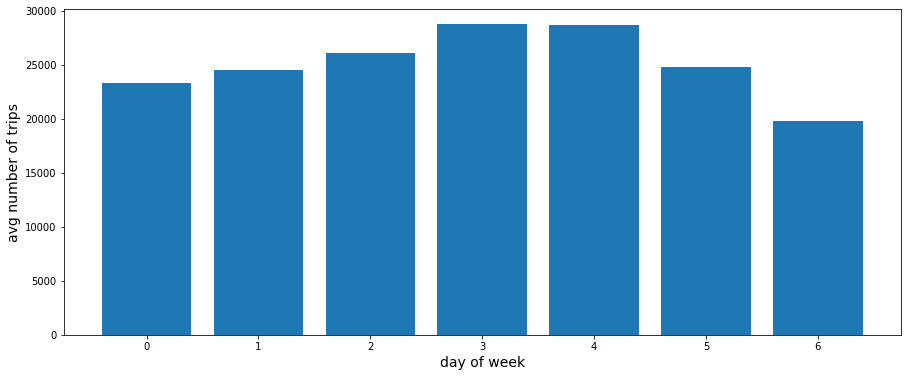

In [21]:
# Plot results
plt.figure(figsize=(15,6))
plt.bar(avg_trip_weekday['DOW'], avg_trip_weekday['count'])
plt.ylabel('avg number of trips', fontsize=14)
plt.xlabel('day of week', fontsize=14)
plt.show()

In [17]:
# Task 2: Plot average total fare amount by hour of pick up time

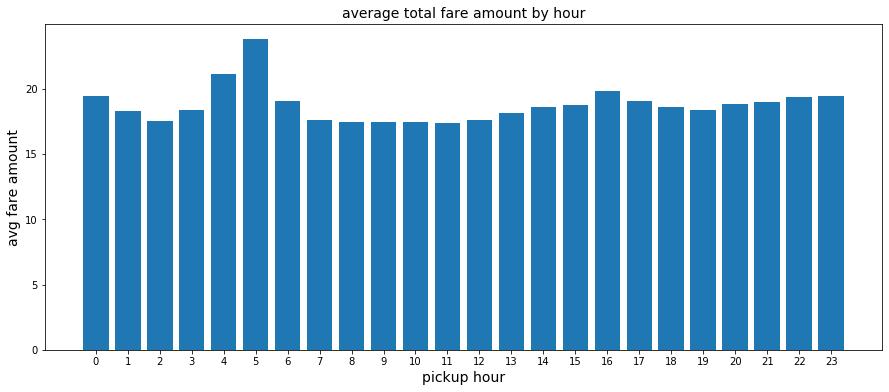

In [40]:
df['hour'] = df['tpep_pickup_datetime'].dt.hour
fare_avg = df[['hour', 'total_amount']].groupby('hour').mean().reset_index().compute()

plt.figure(figsize=(15,6))
plt.bar(fare_avg['hour'], fare_avg['total_amount'])
plt.title("average total fare amount by hour", fontsize=14)
plt.ylabel('avg fare amount', fontsize=14)
plt.xlabel('pickup hour', fontsize=14)
plt.xticks(fare_avg['hour'])
plt.show()

In [22]:
# Task 3: Average speed by pick up hour 

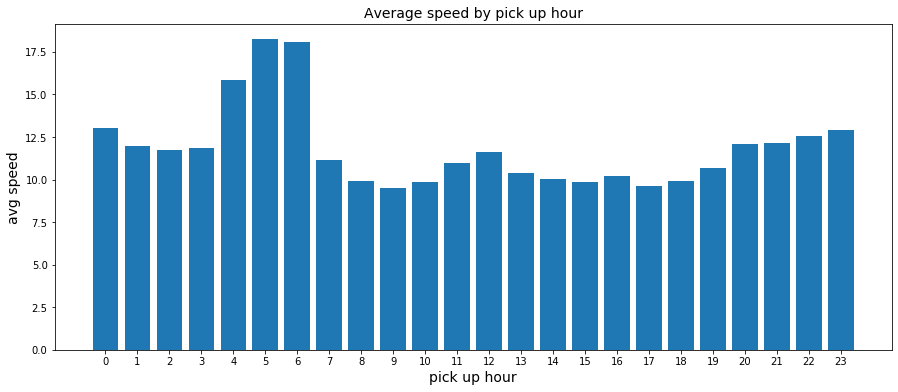

In [26]:
avg_speed =  df[['hour', 'trip_distance', 'travel_time']].groupby(['hour']).sum().reset_index().compute()
avg_speed['avg_speed'] = avg_speed['trip_distance']/(avg_speed['travel_time']/60)

plt.figure(figsize=(15,6))
plt.bar(avg_speed['hour'], avg_speed['avg_speed'])
plt.title("Average speed by pick up hour", fontsize=14)
plt.ylabel('avg speed', fontsize=14)
plt.xlabel('pick up hour', fontsize=14)
plt.xticks(avg_speed['hour'])
plt.show()

In [28]:
# Task 4

In [29]:
# total distance and avg speed
df_agg =  df[['PULocationID', 'trip_distance', 'travel_time']].groupby(['PULocationID']).sum().reset_index().compute()
df_agg['avg_speed'] = df_agg['trip_distance']/(df_agg['travel_time']/60)
df_agg.head()

,PULocationID,trip_distance,travel_time,avg_speed
0,1,285.88,1758.716667,9.753021
1,2,45.55,128.050000,21.343225
2,3,822.44,2577.066667,19.148282
3,4,13927.03,77828.966667,10.736643
4,5,179.04,477.000000,22.520755


In [30]:
# by total distance
# top
df_agg.sort_values(by='trip_distance', ascending=False).head(5)

,PULocationID,trip_distance,travel_time,avg_speed
125,132,1407000.81,3.645949e+06,23.154481
131,138,547615.48,1.881989e+06,17.458615
154,161,313738.16,2.242349e+06,8.394898
228,236,294622.72,1.658354e+06,10.659586
222,230,293733.09,1.822055e+06,9.672589


In [31]:
# bottom
df_agg.sort_values(by='trip_distance', ascending=True).head(5)

,PULocationID,trip_distance,travel_time,avg_speed
165,172,3.45,15.100000,13.708609
104,111,5.65,20.950000,16.181384
176,184,9.43,71.716667,7.889380
196,204,21.40,31.100000,41.286174
179,187,26.99,47.450000,34.128556


In [32]:
# by avg speed
# top
df_agg.sort_values(by='avg_speed', ascending=False).head()

,PULocationID,trip_distance,travel_time,avg_speed
28,29,51340.63,2480.216667,1242.003508
128,135,70689.21,5172.600000,819.965317
149,156,35.06,47.266667,44.504937
5,6,71.70,97.016667,44.342896
196,204,21.40,31.100000,41.286174


In [39]:
# disregard the first two (unreasonable)

df_agg.sort_values(by='avg_speed', ascending=False)[2:7]

,PULocationID,trip_distance,travel_time,avg_speed
149,156,35.06,47.266667,44.504937
5,6,71.70,97.016667,44.342896
196,204,21.40,31.100000,41.286174
243,251,114.86,177.483333,38.829561
22,23,830.87,1321.433333,37.725853


In [34]:
# bottom
df_agg.sort_values(by='avg_speed', ascending=True).head()

,PULocationID,trip_distance,travel_time,avg_speed
7,8,208.45,3372.783333,3.708213
191,199,69.08,974.516667,4.253185
113,120,130.98,1812.650000,4.335531
29,31,181.91,1920.633333,5.682813
209,217,546.30,4234.800000,7.740153


## Machine learning operations with Dask

### Dask-ML

Dask-ML provides some ensemble methods that are tailored to dask.array’s and dask.dataframe’s blocked structure. The basic idea is to fit a copy of some sub-estimator to each block (or partition) of the dask Array or DataFrame. Becuase each block fits in memory, the sub-estimator only needs to handle in-memory data structures like a NumPy array or pandas DataFrame. It also will be relatively fast, since each block fits in memory and we won’t need to move large amounts of data between workers on a cluster. We end up with an ensemble of models: one per block in the training dataset.

At prediction time, we combine the results from all the models in the ensemble. For regression problems, this means averaging the predictions from each sub-estimator. For classification problems, each sub-estimator votes and the results are combined.

#### Note: 
It’s crucially important that the distribution of values in your dataset be relatively uniform across partitions. Otherwise the parameters learned on any given partition would vary widely and might not be well applicable to the dataset as a whole.

In [32]:
import dask_ml.datasets
import dask_ml.ensemble

## try linear regression 
from dask_ml.linear_model import LinearRegression
from dask_ml.model_selection import train_test_split

X, y = dask_ml.datasets.make_regression(n_samples=1_000_000,
                                        chunks=100_000,
                                        n_features=20)
X

dask.array<normal, shape=(1000000, 20), dtype=float64, chunksize=(100000, 20), chunktype=numpy.ndarray>

In [33]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [48]:
## by default: dask-array
## with .compute() we get a numpy array

lr.predict(X)[:5].compute() 

array([ 138.31868227, -104.66293123,   66.35378657,  107.73458415,
       -137.30441425])

In [49]:
(lr.intercept_, lr.coef_)

(3.3208678168472616e-10,
 array([ 1.61643145e-07,  5.84265605e+01,  2.77167537e+00,  1.02590946e+01,
        -5.40924232e-08,  1.68925917e-08,  5.86754174e-08,  5.70898978e-10,
         7.95140555e+01,  5.54583054e-08,  1.16131178e+01, -3.20890122e-08,
         4.61853390e-08,  5.50610039e+00,  8.15375681e+01,  7.74914596e+01,
        -1.13660139e-07, -7.07052834e-08,  6.88340202e+00,  4.46162411e+01]))

In [50]:
lr.score(X, y)

0.9999999952647298

In [51]:
# try K-means clustering
import dask_ml.cluster

X, y = dask_ml.datasets.make_blobs(n_samples=1000000,
                                   chunks=100000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(1000000, 2), dtype=float64, chunksize=(100000, 2), chunktype=numpy.ndarray>

In [52]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

KMeans(init_max_iter=2, n_clusters=3, oversampling_factor=10)

In [53]:
## call without compute

km.labels_[::1000]

dask.array<getitem, shape=(1000,), dtype=int32, chunksize=(100,), chunktype=numpy.ndarray>

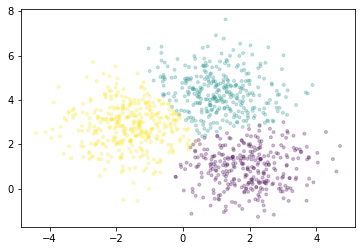

In [54]:
## if we directly pass them to the plot, we don't need .compute()

fig, ax = plt.subplots()
ax.scatter(X[::1000, 0], X[::1000, 1], marker='.', c=km.labels_[::1000], 
           cmap='viridis', alpha=0.25);

Note: dask_ml operations process dask objects instead of numpy arrays or pandas dataframe. Unless we want to print results as numpy array or pandas dataframe, we don't need to call compute. This makes dask_ml much faster than other libraries like sklearn. 

## Dask_ml for learning average speed in the taxi data

Implement a linear regression of the travel time vs the trip distance

In [34]:
lr_taxi = LinearRegression(fit_intercept=False)
lr_taxi.fit(df[['trip_distance']].to_dask_array(),df[['travel_time']].to_dask_array())

LinearRegression(fit_intercept=False)

In [35]:
lr_taxi.coef_ #slope coefficient (min per mile)

array([0.00539549])

In [36]:
dist_sample=df[['trip_distance']].to_dask_array().compute()[:10] #take first 10 distances as a sample

In [37]:
#return the predicted vs actual time for the selected sample
## we don't need to call .compute() to get the numpy array 

pd.DataFrame({'distance':dist_sample.flatten(), 'predicted time':lr_taxi.predict(dist_sample), 'actual time': df[['travel_time']].to_dask_array().compute()[:10].flatten()})

,distance,predicted time,actual time
0,1.72,0.009280,11.750000
1,1.21,0.006529,11.700000
2,1.41,0.007608,9.283333
3,2.50,0.013489,16.950000
4,1.69,0.009118,9.283333
5,7.00,0.037768,26.466667
6,1.15,0.006205,9.150000
7,1.50,0.008093,12.216667
8,1.15,0.006205,5.650000
9,0.70,0.003777,5.400000


#### Important note:

Recently, there seem to be some issues with dask_ml model when we train models on custom data and large dask dataframes. dask_ml library is undergoing changes constantly has a lot of bugs and seems to be getting updated frequently. Hence, we'll not demonstrate any examples on real world data with dask_ml.

Check dask_ml's github repo to follow through regular updates: https://github.com/dask/dask-ml

Documentation: https://ml.dask.org/

next we'll see how scikit-learn can be scaled for big-data modeling

## Scalable Scikit-Learn

Alternatively, we can use scikit-learn for training models on medium sized data where pandas would usually fail or would take a huge amount of time.

Scikit-learn uses joblib for single-machine parallelism. This lets you train most estimators (anything that accepts an n_jobs parameter) using all the cores of your laptop or workstation. Alternatively, Scikit-Learn can use Dask for parallelism. This lets you train those estimators using all the cores of your cluster without significantly changing your code.

This is most useful for training large models on medium-sized datasets. You may have a large model when searching over many hyper-parameters, or when using an ensemble method with many individual estimators. For too small datasets, training times will typically be small enough that cluster-wide parallelism isn’t helpful. For too large datasets (larger than a single machine’s memory), the scikit-learn estimators may not be able to cope.

In [ ]:
## paralalize different models with parameter selection

In [51]:
## pipeline: paralel models run

from sklearn.linear_model import LinearRegression as LinReg
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np

Let's now use skearn to build a simple linear model with Lasso regularization with trip cost amount as a target variable and using just trip distance as a regressor. We'll use GridSearchCV for tuning the hyperparameter (alpha) value.

In [39]:
# do some filtering to remove outliers and wrong values
df = df[(df.trip_distance > 0) & (df.trip_distance < 50)]
df = df[(df.total_amount > 0) & (df.total_amount < 300)]
df = df[(df.travel_time > 0) & (df.travel_time < 200)]

In [40]:
# X as features, y as target (note: we need to call compute method, as sklearn only takes numpy arrays)
X = df[['trip_distance','travel_time']].values.compute()
y = df.total_amount.values.compute()

Split the data into training and test

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2002)

#### Create Scikit-Learn Pipeline

Pipeline consist of all the models (or intermediate steps) that we wish to train/perform on the data

In [44]:
# make a pipeline - specify the model
pipeline = Pipeline([
    ('lasso', Lasso(fit_intercept=True))])

# we can specify parameters here we want to optimize
# notice the format - {'model__parameter': range}, this format should follow for all parameters
parameters = {'lasso__alpha': 2.0**(np.arange(-10, 10, 1))}

# call the gridsearch method and fit
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3, refit=True) ## cv is cross-validation setting

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3, estimator=Pipeline(steps=[('lasso', Lasso())]), n_jobs=-1,
             param_grid={'lasso__alpha': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01, 3.200000e+01,
       6.400000e+01, 1.280000e+02, 2.560000e+02, 5.120000e+02])},
             verbose=1)

In [45]:
grid_search.best_params_

{'lasso__alpha': 0.00390625}

In [46]:
# r2 score
grid_search.score(X_test, y_test)

0.8656113227649826

### Homework task 2



With trip cost amount as a target variable and using trip distance, travel time and PULocationID as predictors, build a Random Forest Regression with 10 trees (n_estimators) using the sklearn pipeline to select the hyperparameter 'max_depth' with values from 2 to 5.

Use 75:25 train test split as above, use the training data for GridSearchCV with three-fold cross-validation (cv=3). Report the best max_depth as well as the R2 on test data.

In [48]:
# prepare X as features and y as target

X = df[['trip_distance', 'travel_time', 'PULocationID']].values.compute()
y = df.total_amount.values.compute()

In [49]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2002)

In [59]:
# create pipeline and fit the model

# make a pipeline - specify the model
pipeline = Pipeline([
    ('RandomForest', RandomForestRegressor(n_estimators = 10))])

# parameters to optimize
parameters = {'RandomForest__max_depth': (np.arange(2,5))} ## call the RandomForest from the pipeline

# call the gridsearch method and fit
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3, refit=True) 
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('RandomForest',
                                        RandomForestRegressor(n_estimators=10))]),
             n_jobs=-1,
             param_grid={'RandomForest__max_depth': array([2, 3, 4])},
             verbose=1)

In [60]:
# report test accuracy
grid_search.best_params_

{'RandomForest__max_depth': 4}

In [61]:
grid_search.score(X_test2, y_test2)

0.8612747454585266